# Utilities

## Init example model

In [1]:

# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

import gempy as gp
%matplotlib inline

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 60,60,60],
                         path_f = os.pardir+"/input_data/FabLessPoints_Foliations.csv",
                         path_i = os.pardir+"/input_data/FabLessPoints_Points.csv")

# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest": ('SecondaryReservoir','Seal', 'Reservoir', 'Overlying')},
                       order_series = ["fault", 'Rest'],
                       order_formations=['MainFault', 
                                         'SecondaryReservoir', 'Seal','Reservoir', 'Overlying',
                                         ]) 

interp_data = gp.InterpolatorData(geo_data, u_grade=[1, 1],
                                  output='geology', dtype='float64',
                                  verbose=[],
                                  compile_theano=True)

../../gempy/data_management.py:61: UserWarning: path_f is deprecated use instead path_o
  warnings.warn('path_f is deprecated use instead path_o')


Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


## Change Grid

In [6]:
lith, fault = gp.compute_model_at(np.array([[2,3,4]]), interp_data)

To change the grid there are two parameters of the theano graph that depends on that and therefore we need to change:

1) grid_val_T: The locations (plus the location of the input data) where we want to interpolate
2) universal_grid_mmatrix_T: Term associated with the drift function of the system

Furthermore, we need to consider that the interpolation is performed in a rescaled coordinate system (which is calculated the first time we call InterpolatorData from the location of the input data).

In [ ]:
# First Create a new custom grid using the GridClass
new_grid = gp.GridClass()

# Here we can pass the new coordinates as a 2D numpy array XYZ
new_grid.create_custom_grid(np.array([[2,3,4]]))

# This will be stored in
new_grid.values

In [ ]:
# Next we rescale the data. For this the main parameters are already stored in interp_data
new_grid_res = (new_grid.values  - interp_data.centers.as_matrix()) / interp_data.rescaling_factor + 0.5001
new_grid_res

In [ ]:
# We stack the input data
x_to_interpolate = np.vstack((new_grid_res,
                              interp_data.interpolator.pandas_rest_layer_points[['X', 'Y', 'Z']].as_matrix(),
                              interp_data.interpolator.pandas_ref_layer_points_rep[['X', 'Y', 'Z']].as_matrix()))

# And create the drift function matrix. (This step could be done within theano to speed up a bit)
universal_matrix = np.vstack((x_to_interpolate.T,
                             (x_to_interpolate ** 2).T,
                              x_to_interpolate[:, 0] * x_to_interpolate[:, 1],
                              x_to_interpolate[:, 0] * x_to_interpolate[:, 2],
                              x_to_interpolate[:, 1] * x_to_interpolate[:, 2],
                              ))

In [ ]:
# Last step is to change the variables in the theano graph

interp_data.interpolator.tg.grid_val_T.set_value(np.cast[interp_data.interpolator.dtype](x_to_interpolate + 10e-9))
interp_data.interpolator.tg.universal_grid_matrix_T.set_value(np.cast[interp_data.interpolator.dtype](universal_matrix + 1e-10))

In [ ]:
# Now we are good to compute the model agai only in the new point

In [ ]:
gp.compute_model(interp_data)


## Select series

We can always explore the number of series we have by checking out the sequential pile (with is interactive in qt5 or notebook).

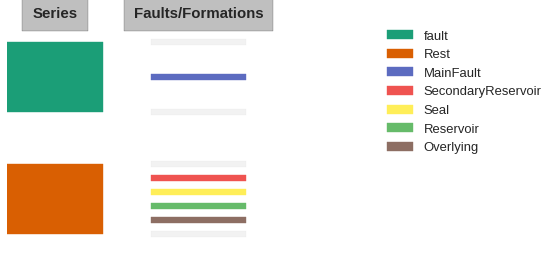

In [4]:
gp.get_sequential_pile(geo_data)

If we want to get a subset of the input data we can select the series we want by simply:

In [7]:
geo_data_subset = gp.select_series(geo_data, ['Rest'])

So now the new geo_data_subset will contain only the data you are interested in:

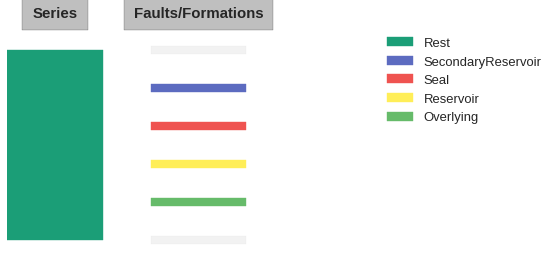

In [8]:
gp.get_sequential_pile(geo_data_subset)

In [9]:
gp.get_data(geo_data_subset)

G_x    G_y       G_z     X     Y      Z azimuth     dip  \
interfaces   0        NaN    NaN       NaN  2000  1000   -775     NaN     NaN   
             1        NaN    NaN       NaN  1600  1000   -700     NaN     NaN   
             2        NaN    NaN       NaN  1900  1000   -800     NaN     NaN   
             3        NaN    NaN       NaN   900  1000   -650     NaN     NaN   
             4        NaN    NaN       NaN   600  1000   -550     NaN     NaN   
             5        NaN    NaN       NaN  1300  1000   -600     NaN     NaN   
             6        NaN    NaN       NaN   900  1000   -750     NaN     NaN   
             7        NaN    NaN       NaN  1900  1000   -900     NaN     NaN   
             8        NaN    NaN       NaN  2000  1000   -875     NaN     NaN   
             9        NaN    NaN       NaN   600  1000   -650     NaN     NaN   
             10       NaN    NaN       NaN  1300  1000   -700     NaN     NaN   
             11       NaN    NaN       NaN  1600  1000   -800     NaN     NaN   
             12       NaN    NaN       NaN   800   200  -1400     NaN     NaN   
             13       NaN    NaN       NaN   800  1800  -1400     NaN     NaN   
             14       NaN    NaN       NaN   600  1000  -1050     NaN     NaN   
             15       NaN    NaN       NaN   300  1000   -950     NaN     NaN   
             16       NaN    NaN       NaN  2000  1000  -1275     NaN     NaN   
             17       NaN    NaN       NaN  1900  1000  -1300     NaN     NaN   
             18       NaN    NaN       NaN  1300  1000  -1100     NaN     NaN   
             19       NaN    NaN       NaN  1600  1000  -1200     NaN     NaN   
             20       NaN    NaN       NaN  1750  1000  -1250     NaN     NaN   
             21       NaN    NaN       NaN  1000   100  -1100     NaN     NaN   
             22       NaN    NaN       NaN  1000  1975  -1050     NaN     NaN   
             23       NaN    NaN       NaN  1000  1900  -1100     NaN     NaN   
             24       NaN    NaN       NaN  1150  1000  -1050     NaN     NaN   
             25       NaN    NaN       NaN  1000    25  -1050     NaN     NaN   
             26       NaN    NaN       NaN   300  1000  -1250     NaN     NaN   
             27       NaN    NaN       NaN  2000  1000  -1575     NaN     NaN   
             28       NaN    NaN       NaN  1300  1000  -1400     NaN     NaN   
             29       NaN    NaN       NaN  1600  1000  -1500     NaN     NaN   
             30       NaN    NaN       NaN  1750  1000  -1550     NaN     NaN   
             31       NaN    NaN       NaN  1000  1000  -1300     NaN     NaN   
             32       NaN    NaN       NaN   600  1000  -1350     NaN     NaN   
             33       NaN    NaN       NaN  1900  1000  -1600     NaN     NaN   
orientations 1   0.316229  1e-07  0.948683  1450  1000  -1150      90  18.435   

                          formation polarity series  
interfaces   0   SecondaryReservoir      NaN   Rest  
             1   SecondaryReservoir      NaN   Rest  
             2   SecondaryReservoir      NaN   Rest  
             3   SecondaryReservoir      NaN   Rest  
             4   SecondaryReservoir      NaN   Rest  
             5   SecondaryReservoir      NaN   Rest  
             6                 Seal      NaN   Rest  
             7                 Seal      NaN   Rest  
             8                 Seal      NaN   Rest  
             9                 Seal      NaN   Rest  
             10                Seal      NaN   Rest  
             11                Seal      NaN   Rest  
             12           Reservoir      NaN   Rest  
             13           Reservoir      NaN   Rest  
             14           Reservoir      NaN   Rest  
             15           Reservoir      NaN   Rest  
             16           Reservoir      NaN   Rest  
             17           Reservoir      NaN   Rest  
             18           Reservoir      NaN   Rest  
             19          